<a href="https://colab.research.google.com/github/caro-vergara-tamara/where-to-live/blob/main/read_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import geopandas as gpd
import fiona
import re
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


In [2]:
from preparing_data.immo_preprocessing import select_and_rename_immo_columns

In [4]:
help(select_and_rename_immo_columns)

Help on function select_and_rename_immo_columns in module preparing_data.immo_preprocessing:

select_and_rename_immo_columns(df)
    Selects relevant columns for the immo dataset and renames them to snake_case.



In [3]:
# read Databases
#import pandas as pd
#pop = pd.read_excel('/content/drive/MyDrive/MFP/Databases_statbel/TF_SOC_POP_STRUCT_2024.xlsx', engine='openpyxl')
#income = pd.read_excel('/content/drive/MyDrive/MFP/Databases_statbel/TF_PSNL_INC_TAX_MUNTY.xlsx', engine='openpyxl')
#pop_sector = pd.read_excel('/content/drive/MyDrive/MFP/Databases_statbel/OPENDATA_SECTOREN_2024.xlsx', engine='openpyxl')
#immo_nis7 = pd.read_excel('data/TF_IMMO_SECTOR_nis_7.xlsx', engine='openpyxl')

In [5]:
# Import immo database
immo = pd.read_excel('data/TF_IMMO_SECTOR.xlsx', engine='openpyxl')
immo.columns

Index(['CD_STAT_SECTOR', 'CD_YEAR', 'CD_TYPE', 'CD_TYPE_NL', 'CD_TYPE_FR',
       'MS_TRANSACTIONS', 'MS_P25', 'MS_P50 (MEDIAN_PRICE)', 'MS_P75',
       'MS_P10', 'MS_P90'],
      dtype='object')

In [6]:
immo = select_and_rename_immo_columns(immo)

# immo = immo[['CD_STAT_SECTOR', 'CD_YEAR', 'CD_TYPE', 'CD_TYPE_FR',
#        'MS_TRANSACTIONS', 'MS_P25', 'MS_P50 (MEDIAN_PRICE)', 'MS_P75',
#        'MS_P10', 'MS_P90']]

# immo.rename(columns={
#     'CD_STAT_SECTOR': 'cd_stat_sector', 
#     'CD_YEAR': 'cd_year', 
#     'CD_TYPE': 'cd_type', 
#     'MS_TRANSACTIONS': 'n', 
#     'MS_P25': 'p25', 
#     'MS_P50 (MEDIAN_PRICE)': 'p50', 
#     'MS_P75': 'p75',
#     'MS_P10': 'p10', 
#     'MS_P90': 'p90'
# }, inplace=True)

In [7]:
immo.columns # good good good

Index(['cd_stat_sector', 'cd_year', 'cd_type', 'CD_TYPE_FR', 'n', 'p25', 'p50',
       'p75', 'p10', 'p90'],
      dtype='object')

In [5]:
# Add geographical data
geo_data = pd.read_parquet("data/geo_data_2024.parquet")
geo_data.columns
geo_data = geo_data.rename({'cd_sector' : 'cd_stat_sector'}, axis = "columns")
geo_data.columns
immo['cd_stat_sector'] = immo['cd_stat_sector'].astype(str).str.strip()
geo_data['cd_stat_sector'] = geo_data['cd_stat_sector'].astype(str).str.strip()
# Adding geo information
immo = immo.merge(geo_data, how = "left", on = "cd_stat_sector")
#immo.head()


Index(['cd_stat_sector', 'cd_sub_munty', 'cd_munty_refnis', 'cd_dstr_refnis',
       'cd_prov_refnis', 'cd_rgn_refnis'],
      dtype='object')

In [8]:
immo.isnull().sum()          

cd_stat_sector          0
cd_year                 0
cd_type                 0
CD_TYPE_FR              0
n                       0
p25                429771
p50                429771
p75                429771
p10                429771
p90                429771
cd_sub_munty        10034
cd_munty_refnis     10034
cd_dstr_refnis      10034
cd_prov_refnis      27390
cd_rgn_refnis       10034
dtype: int64

In [13]:
mask_missing = immo['cd_sub_munty'].isnull()

# Check if all rows with missing 'cd_sub_munty' have '_UNKNOWN' in 'cd_stat_sector'
all_unknown = immo.loc[mask_missing, 'cd_stat_sector'].str.endswith('_UNKNOWN').all()

immo.loc[mask_missing, 'cd_stat_sector'].sample(10)

2775          11002J81-
321876    62015_UNKNOWN
116379    24109_UNKNOWN
297637    56049_UNKNOWN
24131     11055_UNKNOWN
372491    71024_UNKNOWN
113373    24094_UNKNOWN
296054    56016_UNKNOWN
288503    55022_UNKNOWN
439583    92087_UNKNOWN
Name: cd_stat_sector, dtype: object

In [14]:
print("✅ All missing are _UNKNOWN:", all_unknown)

✅ All missing are _UNKNOWN: False


In [15]:
mask_missing.tail()

456844    True
456845    True
456846    True
456847    True
456848    True
Name: cd_sub_munty, dtype: bool

In [16]:
# Now find the rows where cd_stat_sector does NOT end with "_UNKNOWN"
not_unknown_mask = ~immo.loc[mask_missing, 'cd_stat_sector'].str.endswith('_UNKNOWN')

# Get those rows
suspicious_rows = immo.loc[mask_missing].loc[not_unknown_mask]

# Display the problematic cd_stat_sector values
print(suspicious_rows['cd_stat_sector'].unique())


['11002J81-' '11002J901' '11002J912' '11002J923' '11002J932' '11002J94-'
 '11002P21-' '11002Q2PA' '52043A10-' '52043B01-' '52063A372' '62108F09-'
 '62108F19-']


In [ ]:
##################  ATENTION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# i THINK THAT FOR EXAMPLE 11002J CAN BE EXTRACTED! AND THEN DO THE MERGE 

# So when we can do the merge, perfect, otherwise, 
# there are two options: 
# Option one: there are cd_stat sector that cannot be merged, but where we can extract the info we need. Like 
#['11002J81-' '11002J901' '11002J912' '11002J923' '11002J932' '11002J94-' '11002P21-' '11002Q2PA' '52043A10-' '52043B01-' '52063A372' '62108F09-' '62108F19-']
# Option two: when there's '_UNKNOWN' added to the cd_stat_sector, in that case we can only extract cd_munty_refnis onwards..


In [18]:
suspicious_rows

,cd_stat_sector,cd_year,cd_type,CD_TYPE_FR,n,p25,p50,p75,p10,p90,cd_sub_munty,cd_munty_refnis,cd_dstr_refnis,cd_prov_refnis,cd_rgn_refnis
2764,11002J81-,2013,B001,Maisons avec 2 ou 3 façades (type fermé + type...,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2765,11002J81-,2014,B001,Maisons avec 2 ou 3 façades (type fermé + type...,15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2766,11002J81-,2015,B001,Maisons avec 2 ou 3 façades (type fermé + type...,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2767,11002J81-,2016,B001,Maisons avec 2 ou 3 façades (type fermé + type...,16,160000.0,177500.0,200950.0,150000.0,228000.0,NaN,NaN,NaN,NaN,NaN
2768,11002J81-,2017,B001,Maisons avec 2 ou 3 façades (type fermé + type...,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
339264,62108F19-,2017,B001,Maisons avec 2 ou 3 façades (type fermé + type...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
339265,62108F19-,2015,B00A,"Toutes les maisons avec 2, 3, 4 ou plus de faç...",5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
339266,62108F19-,2016,B00A,"Toutes les maisons avec 2, 3, 4 ou plus de faç...",1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
339267,62108F19-,2017,B00A,"Toutes les maisons avec 2, 3, 4 ou plus de faç...",1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
# Option one - Part One
# So from mask missing...
suspicious_rows.columns

suspicious_rows['cd_sub_munty'] = suspicious_rows['cd_stat_sector'].str.extract(r'^(.{6})')
suspicious_rows['cd_munty_refnis'] = suspicious_rows['cd_stat_sector'].str.extract(r'^(.{5})')
suspicious_rows['cd_dstr_refnis'] = suspicious_rows['cd_stat_sector'].str[:5].str.replace(r'\d{2}$', '00', regex=True)
suspicious_rows['cd_prov_refnis'] = suspicious_rows['cd_stat_sector'].str[:5].str.replace(r'\d{4}$', '0000', regex=True)

suspicious_rows[['cd_stat_sector', 'cd_sub_munty', 'cd_munty_refnis', 'cd_dstr_refnis', 'cd_prov_refnis']]

,cd_stat_sector,cd_sub_munty,cd_munty_refnis,cd_dstr_refnis,cd_prov_refnis
2764,11002J81-,11002J,11002,11000,10000
2765,11002J81-,11002J,11002,11000,10000
2766,11002J81-,11002J,11002,11000,10000
2767,11002J81-,11002J,11002,11000,10000
2768,11002J81-,11002J,11002,11000,10000
...,...,...,...,...,...
339264,62108F19-,62108F,62108,62100,60000
339265,62108F19-,62108F,62108,62100,60000
339266,62108F19-,62108F,62108,62100,60000
339267,62108F19-,62108F,62108,62100,60000


In [20]:
# Option one - Part Two

region_province = geo_data.groupby('cd_prov_refnis')['cd_rgn_refnis'].unique()
region_province = region_province.map(lambda x: x[0] if len(x) > 0 else None)

suspicious_rows = suspicious_rows.drop(columns = ['cd_rgn_refnis'])
suspicious_rows = suspicious_rows.merge(region_province, how = 'left', on = 'cd_prov_refnis')
suspicious_rows

,cd_stat_sector,cd_year,cd_type,CD_TYPE_FR,n,p25,p50,p75,p10,p90,cd_sub_munty,cd_munty_refnis,cd_dstr_refnis,cd_prov_refnis,cd_rgn_refnis
0,11002J81-,2013,B001,Maisons avec 2 ou 3 façades (type fermé + type...,10,NaN,NaN,NaN,NaN,NaN,11002J,11002,11000,10000,02000
1,11002J81-,2014,B001,Maisons avec 2 ou 3 façades (type fermé + type...,15,NaN,NaN,NaN,NaN,NaN,11002J,11002,11000,10000,02000
2,11002J81-,2015,B001,Maisons avec 2 ou 3 façades (type fermé + type...,11,NaN,NaN,NaN,NaN,NaN,11002J,11002,11000,10000,02000
3,11002J81-,2016,B001,Maisons avec 2 ou 3 façades (type fermé + type...,16,160000.0,177500.0,200950.0,150000.0,228000.0,11002J,11002,11000,10000,02000
4,11002J81-,2017,B001,Maisons avec 2 ou 3 façades (type fermé + type...,12,NaN,NaN,NaN,NaN,NaN,11002J,11002,11000,10000,02000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,62108F19-,2017,B001,Maisons avec 2 ou 3 façades (type fermé + type...,1,NaN,NaN,NaN,NaN,NaN,62108F,62108,62100,60000,03000
115,62108F19-,2015,B00A,"Toutes les maisons avec 2, 3, 4 ou plus de faç...",5,NaN,NaN,NaN,NaN,NaN,62108F,62108,62100,60000,03000
116,62108F19-,2016,B00A,"Toutes les maisons avec 2, 3, 4 ou plus de faç...",1,NaN,NaN,NaN,NaN,NaN,62108F,62108,62100,60000,03000
117,62108F19-,2017,B00A,"Toutes les maisons avec 2, 3, 4 ou plus de faç...",1,NaN,NaN,NaN,NaN,NaN,62108F,62108,62100,60000,03000


In [30]:
# Option Two ----> HERE WE WILL TREAT THE UNKNOWN


mask_unknown = ( immo['cd_sub_munty'].isnull() & immo['cd_stat_sector'].str.endswith('_UNKNOWN'))

unknown_rows = immo.loc[mask_unknown]

unknown_rows['cd_munty_refnis'] = unknown_rows['cd_stat_sector'].str.extract(r'^(.{5})')
unknown_rows['cd_dstr_refnis'] = unknown_rows['cd_stat_sector'].str[:5].str.replace(r'\d{2}$', '00', regex=True)
unknown_rows['cd_prov_refnis'] = unknown_rows['cd_stat_sector'].str[:5].str.replace(r'\d{4}$', '0000', regex=True)


unknown_rows = unknown_rows.drop(columns = ['cd_rgn_refnis'])
unknown_rows = unknown_rows.merge(region_province, how = 'left', on = 'cd_prov_refnis')
unknown_rows

unknown_rows[['cd_stat_sector', 'cd_sub_munty', 'cd_munty_refnis', 'cd_dstr_refnis', 'cd_prov_refnis', 'cd_rgn_refnis']]

C:\Users\carol\AppData\Local\Temp\ipykernel_13364\455192714.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unknown_rows['cd_munty_refnis'] = unknown_rows['cd_stat_sector'].str.extract(r'^(.{5})')
C:\Users\carol\AppData\Local\Temp\ipykernel_13364\455192714.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unknown_rows['cd_dstr_refnis'] = unknown_rows['cd_stat_sector'].str[:5].str.replace(r'\d{2}$', '00', regex=True)
C:\Users\carol\AppData\Local\Temp\ipykernel_13364\455192714.py:10: SettingWithCopyWarn

,cd_stat_sector,cd_sub_munty,cd_munty_refnis,cd_dstr_refnis,cd_prov_refnis,cd_rgn_refnis
0,11001_UNKNOWN,NaN,11001,11000,10000,02000
1,11001_UNKNOWN,NaN,11001,11000,10000,02000
2,11001_UNKNOWN,NaN,11001,11000,10000,02000
3,11001_UNKNOWN,NaN,11001,11000,10000,02000
4,11001_UNKNOWN,NaN,11001,11000,10000,02000
...,...,...,...,...,...,...
9910,93090_UNKNOWN,NaN,93090,93000,90000,03000
9911,93090_UNKNOWN,NaN,93090,93000,90000,03000
9912,93090_UNKNOWN,NaN,93090,93000,90000,03000
9913,93090_UNKNOWN,NaN,93090,93000,90000,03000


In [41]:
# Merging all together

not_missing_immo = immo[~immo['cd_sub_munty'].isnull()]
not_missing_immo

not_missing_immo_and_unknown_rows = pd.concat([not_missing_immo, unknown_rows], ignore_index=True)
full_db = pd.concat([not_missing_immo_and_unknown_rows, suspicious_rows], ignore_index=True)

print("✅ Do databases match? :", full_db.shape == immo.shape)


✅ Do databases match? : True


In [42]:
immo = full_db 
# which columns the database has and weather it has many missing values
print(immo.info())

#Number rows and coulumns
print(immo.shape)

# tenemos years del 13 al 23 para cada sector estadistico
#https://statbel.fgov.be/en/search?search_api_fulltext_block=Statistical%20sectors&f%5B0%5D=theme_search%3A1390


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 456849 entries, 0 to 456848
Data columns (total 15 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   cd_stat_sector   456849 non-null  object 
 1   cd_year          456849 non-null  int64  
 2   cd_type          456849 non-null  object 
 3   CD_TYPE_FR       456849 non-null  object 
 4   n                456849 non-null  int64  
 5   p25              27078 non-null   float64
 6   p50              27078 non-null   float64
 7   p75              27078 non-null   float64
 8   p10              27078 non-null   float64
 9   p90              27078 non-null   float64
 10  cd_sub_munty     446934 non-null  object 
 11  cd_munty_refnis  456849 non-null  object 
 12  cd_dstr_refnis   456849 non-null  object 
 13  cd_prov_refnis   439493 non-null  object 
 14  cd_rgn_refnis    455041 non-null  object 
dtypes: float64(5), int64(2), object(8)
memory usage: 52.3+ MB
None
(456849, 15)


In [43]:
immo.columns  

Index(['cd_stat_sector', 'cd_year', 'cd_type', 'CD_TYPE_FR', 'n', 'p25', 'p50',
       'p75', 'p10', 'p90', 'cd_sub_munty', 'cd_munty_refnis',
       'cd_dstr_refnis', 'cd_prov_refnis', 'cd_rgn_refnis'],
      dtype='object')

In [44]:
immo.dtypes         # Data types of each column

cd_stat_sector      object
cd_year              int64
cd_type             object
CD_TYPE_FR          object
n                    int64
p25                float64
p50                float64
p75                float64
p10                float64
p90                float64
cd_sub_munty        object
cd_munty_refnis     object
cd_dstr_refnis      object
cd_prov_refnis      object
cd_rgn_refnis       object
dtype: object

In [45]:
immo.head()         # First 5 rows

,cd_stat_sector,cd_year,cd_type,CD_TYPE_FR,n,p25,p50,p75,p10,p90,cd_sub_munty,cd_munty_refnis,cd_dstr_refnis,cd_prov_refnis,cd_rgn_refnis
0,11001A00-,2013,B001,Maisons avec 2 ou 3 façades (type fermé + type...,17,190000.0,266000.0,320000.0,160000.0,350000.0,11001A,11001,11000,10000,02000
1,11001A00-,2014,B001,Maisons avec 2 ou 3 façades (type fermé + type...,20,197500.0,233750.0,294000.0,170000.0,353750.0,11001A,11001,11000,10000,02000
2,11001A00-,2015,B001,Maisons avec 2 ou 3 façades (type fermé + type...,14,NaN,NaN,NaN,NaN,NaN,11001A,11001,11000,10000,02000
3,11001A00-,2016,B001,Maisons avec 2 ou 3 façades (type fermé + type...,16,NaN,NaN,NaN,NaN,NaN,11001A,11001,11000,10000,02000
4,11001A00-,2017,B001,Maisons avec 2 ou 3 façades (type fermé + type...,20,240000.0,305600.0,339000.0,168500.0,462000.0,11001A,11001,11000,10000,02000


In [46]:
immo.isnull().sum()                # Count missing values per column

cd_stat_sector          0
cd_year                 0
cd_type                 0
CD_TYPE_FR              0
n                       0
p25                429771
p50                429771
p75                429771
p10                429771
p90                429771
cd_sub_munty         9915
cd_munty_refnis         0
cd_dstr_refnis          0
cd_prov_refnis      17356
cd_rgn_refnis        1808
dtype: int64

In [47]:
# I want to check if there's a particular year that has more missing information than other, 
immo.groupby("cd_year").apply(lambda x: x.isnull().sum())

# The previous years tend to have more missing data

C:\Users\carol\AppData\Local\Temp\ipykernel_13364\3826317172.py:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  immo.groupby("cd_year").apply(lambda x: x.isnull().sum())


,cd_stat_sector,cd_year,cd_type,CD_TYPE_FR,n,p25,p50,p75,p10,p90,cd_sub_munty,cd_munty_refnis,cd_dstr_refnis,cd_prov_refnis,cd_rgn_refnis
cd_year,,,,,,,,,,,,,,,
2013,0,0,0,0,0,37355,37355,37355,37355,37355,1779,0,0,1565,332
2014,0,0,0,0,0,38534,38534,38534,38534,38534,1789,0,0,1505,332
2015,0,0,0,0,0,38164,38164,38164,38164,38164,1249,0,0,1552,238
2016,0,0,0,0,0,38628,38628,38628,38628,38628,736,0,0,1550,135
2017,0,0,0,0,0,38933,38933,38933,38933,38933,651,0,0,1592,115
2018,0,0,0,0,0,39681,39681,39681,39681,39681,658,0,0,1616,130
2019,0,0,0,0,0,39499,39499,39499,39499,39499,643,0,0,1600,119
2020,0,0,0,0,0,39493,39493,39493,39493,39493,543,0,0,1563,83
2021,0,0,0,0,0,39901,39901,39901,39901,39901,681,0,0,1618,115


In [48]:
immo['CD_TYPE_FR'].unique()

array(['Maisons avec 2 ou 3 façades (type fermé + type demi-fermé)',
       'Maisons avec 4 ou plus de façades (type ouvert)',
       'Toutes les maisons avec 2, 3, 4 ou plus de façades (excl. appartements)',
       'Appartements'], dtype=object)

In [49]:
immo['cd_type'].unique()

array(['B001', 'B002', 'B00A', 'B015'], dtype=object)

In [50]:
immo.groupby('cd_type')["CD_TYPE_FR"].unique()

cd_type
B001    [Maisons avec 2 ou 3 façades (type fermé + typ...
B002    [Maisons avec 4 ou plus de façades (type ouvert)]
B00A    [Toutes les maisons avec 2, 3, 4 ou plus de fa...
B015                                       [Appartements]
Name: CD_TYPE_FR, dtype: object

In [51]:
df = immo.groupby(['cd_type', "cd_year"])["p50"].mean().reset_index()

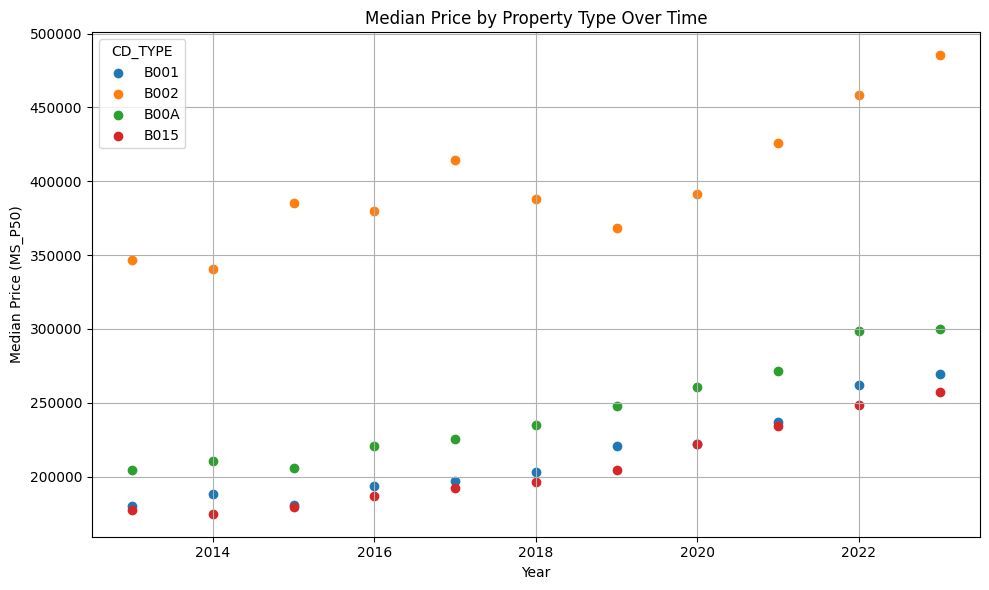

In [52]:
import matplotlib.pyplot as plt

# Assuming df is your grouped DataFrame with CD_TYPE, CD_YEAR, and MS_P50
plt.figure(figsize=(10, 6))

for cd_type, group in df.groupby('cd_type'):
    plt.scatter(group['cd_year'], group['p50'], label=cd_type)

plt.xlabel("Year")
plt.ylabel("Median Price (MS_P50)")
plt.title("Median Price by Property Type Over Time")
plt.legend(title="CD_TYPE")
plt.grid(True)
plt.tight_layout()
plt.show()


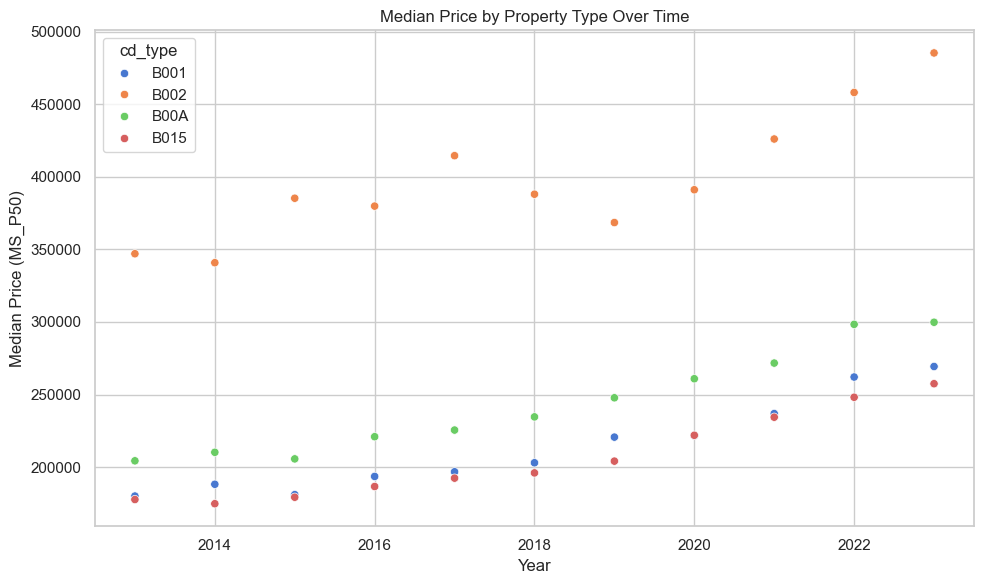

In [54]:
# trying a different library hehe 
plt.figure(figsize=(10, 6))
sns.set_theme(style="whitegrid", palette="muted")
sns.scatterplot(data=df, x='cd_year', y='p50', hue='cd_type')

plt.xlabel("Year")
plt.ylabel("Median Price (MS_P50)")
plt.title("Median Price by Property Type Over Time")
plt.grid(True)
plt.tight_layout()
plt.show()


In [55]:
df["source"] = "original"

In [60]:
immo.columns

Index(['cd_stat_sector', 'cd_year', 'cd_type', 'CD_TYPE_FR', 'n', 'p25', 'p50',
       'p75', 'p10', 'p90', 'cd_sub_munty', 'cd_munty_refnis',
       'cd_dstr_refnis', 'cd_prov_refnis', 'cd_rgn_refnis'],
      dtype='object')

In [69]:
immo.isnull().sum()

cd_stat_sector          0
cd_year                 0
cd_type                 0
CD_TYPE_FR              0
n                       0
p25                429771
p50                429771
p75                429771
p10                429771
p90                429771
cd_sub_munty         9915
cd_munty_refnis         0
cd_dstr_refnis          0
cd_prov_refnis      17356
cd_rgn_refnis        1808
dtype: int64

In [83]:
def fill_hierarchy_by_type(df, target_col, type_col='cd_type',
                           levels=('cd_sub_munty','cd_munty_refnis','cd_dstr_refnis','cd_prov_refnis'),
                           agg='mean'):
    """
    Fill NaNs in `target_col` by cascading from fine -> coarse geography,
    but always within the same `cd_type`.

    agg: 'mean' (default) or 'median' etc.
    """
    df_copy = df.copy()

    for level in levels:
        # compute stat on the ORIGINAL df to avoid leakage from previous fills
        group_stat = df.groupby([level, type_col])[target_col].transform(agg)

        # fill only where still missing in the working copy
        mask = df_copy[target_col].isna()
        df_copy.loc[mask, target_col] = group_stat[mask]

    return df_copy

In [85]:
immo_ = immo

for pct in ['p10', 'p25', 'p50', 'p75', 'p90']:
    immo_ = fill_hierarchy(immo_, pct)

In [86]:
immo_.isnull().sum()

cd_stat_sector         0
cd_year                0
cd_type                0
CD_TYPE_FR             0
n                      0
p25                    0
p50                    0
p75                    0
p10                    0
p90                    0
cd_sub_munty        9915
cd_munty_refnis        0
cd_dstr_refnis         0
cd_prov_refnis     17356
cd_rgn_refnis       1808
dtype: int64

In [77]:
# Now expanding the data from aglomerated to units

def expand_to_synthetic_transactions(df):
    """
    Given a DataFrame with quantiles and number of transactions per group (e.g. region-year-type),
    generates a synthetic transaction-level dataset.

    Required columns in df:
        - 'cd_stat_sector', 'cd_year', 'cd_type'
        - 'p10', 'p25', 'p50', 'p75', 'p90', 'n'

    Returns:
        A DataFrame of synthetic prices with metadata and a 'source' column.
    """

    def generate_synthetic_prices(p10, p25, p50, p75, p90, n):
        quantiles = [0.1, 0.25, 0.5, 0.75, 0.9]
        values = [p10, p25, p50, p75, p90]
        probs = np.random.uniform(0.1, 0.9, size=n)
        return np.interp(probs, quantiles, values)

    # Drop rows with missing data
    df_clean = df.dropna(subset=['p10', 'p25', 'p50', 'p75', 'p90', 'n'])

    synthetic_rows = []

    for _, row in df_clean.iterrows():
        prices = generate_synthetic_prices(
            p10=row['p10'], p25=row['p25'], p50=row['p50'],
            p75=row['p75'], p90=row['p90'], n=int(row['n'])
        )
        for price in prices:
            synthetic_rows.append({
                'cd_stat_sector': row['cd_stat_sector'],
                'cd_year': row['cd_year'],
                'cd_type': row['cd_type'],
                'price': price,
                'source': 'synthetic'
            })

    return pd.DataFrame(synthetic_rows)


In [78]:
synthetic_df = expand_to_synthetic_transactions(immo)

In [79]:
synthetic_df.sample(6)

,cd_stat_sector,cd_year,cd_type,price,source
36381,11002Q012,2020,B00A,186797.428692,synthetic
438511,38014A11-,2021,B015,124687.709683,synthetic
1891,11002A00-,2023,B015,808139.248254,synthetic
584751,52011E50-,2016,B00A,129382.523025,synthetic
601655,53028A012,2023,B00A,82558.620477,synthetic
538705,44021M01-,2014,B00A,202473.717122,synthetic


In [80]:
db = synthetic_df

In [ ]:
####################################### 
#########################
# HERE WE WILL MAKE THE GEO PLOTS 

In [82]:
# Now we make geo plots
# before we used by NIS9, which is more granular, buuutttt not the data on which we did the transformations 
db.head()
db = db.rename({"cd_stat_sector": "cd_sector"}, axis='columns')
immo_nis9 = gdf_2024.merge(db, how="left", on="cd_sector")


NameError: name 'gdf_2024' is not defined

In [89]:
cleaned_db = db.dropna()
db = db.rename({"CD_STAT_SECTOR": "cd_sector"}, axis='columns')



In [6]:
immo_2023 = immo[(immo['CD_YEAR'] == 2023) & (immo['CD_TYPE'] == 'B00A')]
immo_2023.head()

cleaned_immo_2023 = immo_2023.dropna()
cleaned_immo_2023.head()
unique_values = cleaned_immo_2023['CD_STAT_SECTOR'].unique()
unique_values
len(pd.unique(cleaned_immo_2023['CD_STAT_SECTOR']))

939

In [ ]:
immo_2023

,CD_STAT_SECTOR,CD_YEAR,CD_TYPE,CD_TYPE_NL,CD_TYPE_FR,MS_TRANSACTIONS,MS_P25,MS_P50 (MEDIAN_PRICE),MS_P75,MS_P10,MS_P90
27,11001A00-,2023,B00A,"Alle huizen met 2, 3, 4 of meer gevels (excl. ...","Toutes les maisons avec 2, 3, 4 ou plus de faç...",12,NaN,NaN,NaN,NaN,NaN
71,11001A01-,2023,B00A,"Alle huizen met 2, 3, 4 of meer gevels (excl. ...","Toutes les maisons avec 2, 3, 4 ou plus de faç...",33,347000.0,422000.0,580000.0,296500.0,680000.0
115,11001A020,2023,B00A,"Alle huizen met 2, 3, 4 of meer gevels (excl. ...","Toutes les maisons avec 2, 3, 4 ou plus de faç...",9,NaN,NaN,NaN,NaN,NaN
148,11001A030,2023,B00A,"Alle huizen met 2, 3, 4 of meer gevels (excl. ...","Toutes les maisons avec 2, 3, 4 ou plus de faç...",4,NaN,NaN,NaN,NaN,NaN
181,11001A042,2023,B00A,"Alle huizen met 2, 3, 4 of meer gevels (excl. ...","Toutes les maisons avec 2, 3, 4 ou plus de faç...",5,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
456721,93090G032,2023,B00A,"Alle huizen met 2, 3, 4 of meer gevels (excl. ...","Toutes les maisons avec 2, 3, 4 ou plus de faç...",3,NaN,NaN,NaN,NaN,NaN
456735,93090G043,2023,B00A,"Alle huizen met 2, 3, 4 of meer gevels (excl. ...","Toutes les maisons avec 2, 3, 4 ou plus de faç...",2,NaN,NaN,NaN,NaN,NaN
456762,93090G091,2023,B00A,"Alle huizen met 2, 3, 4 of meer gevels (excl. ...","Toutes les maisons avec 2, 3, 4 ou plus de faç...",1,NaN,NaN,NaN,NaN,NaN
456787,93090G191,2023,B00A,"Alle huizen met 2, 3, 4 of meer gevels (excl. ...","Toutes les maisons avec 2, 3, 4 ou plus de faç...",1,NaN,NaN,NaN,NaN,NaN


In [ ]:
immo_2023 = immo_2023.rename({"CD_STAT_SECTOR": "cd_sector"}, axis='columns')
immo_2023.head()

,cd_sector,CD_YEAR,CD_TYPE,CD_TYPE_NL,CD_TYPE_FR,MS_TRANSACTIONS,MS_P25,MS_P50 (MEDIAN_PRICE),MS_P75,MS_P10,MS_P90
27,11001A00-,2023,B00A,"Alle huizen met 2, 3, 4 of meer gevels (excl. ...","Toutes les maisons avec 2, 3, 4 ou plus de faç...",12,NaN,NaN,NaN,NaN,NaN
71,11001A01-,2023,B00A,"Alle huizen met 2, 3, 4 of meer gevels (excl. ...","Toutes les maisons avec 2, 3, 4 ou plus de faç...",33,347000.0,422000.0,580000.0,296500.0,680000.0
115,11001A020,2023,B00A,"Alle huizen met 2, 3, 4 of meer gevels (excl. ...","Toutes les maisons avec 2, 3, 4 ou plus de faç...",9,NaN,NaN,NaN,NaN,NaN
148,11001A030,2023,B00A,"Alle huizen met 2, 3, 4 of meer gevels (excl. ...","Toutes les maisons avec 2, 3, 4 ou plus de faç...",4,NaN,NaN,NaN,NaN,NaN
181,11001A042,2023,B00A,"Alle huizen met 2, 3, 4 of meer gevels (excl. ...","Toutes les maisons avec 2, 3, 4 ou plus de faç...",5,NaN,NaN,NaN,NaN,NaN


<Axes: >

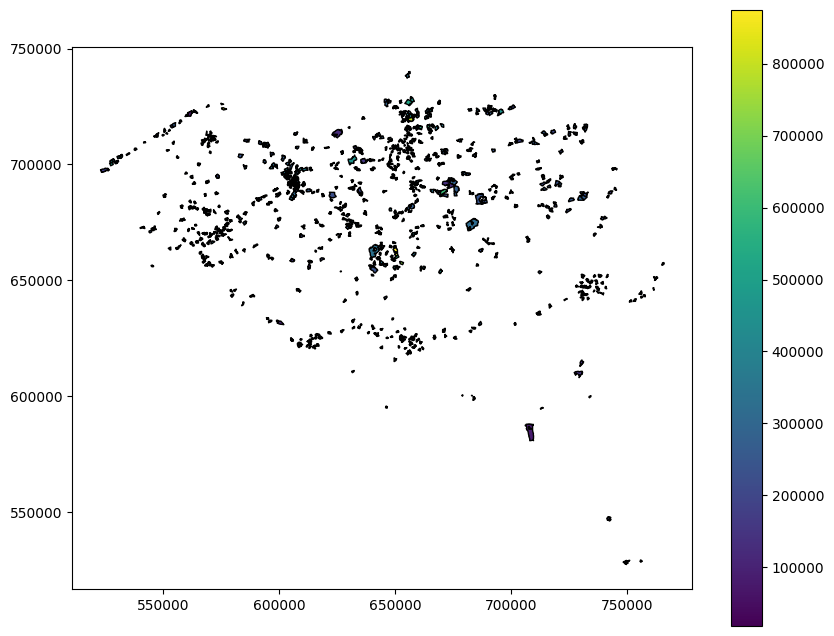

In [ ]:
immo_nis9 = gdf_2024.merge(immo_2023, how="left", on="cd_sector")


# Simple choropleth plot
immo_nis9.plot(column="MS_P25",
         cmap="viridis",
         legend=True,
         figsize=(10, 8),
         edgecolor="black")

In [ ]:
immo_nis7 = immo_nis7[(immo_nis7['CD_YEAR'] == 2023) & (immo_nis7['CD_TYPE'] == 'B00A')]
immo_nis7.head()


,CD_WIJK_QUARTIER,CD_YEAR,CD_TYPE,CD_TYPE_NL,CD_TYPE_FR,MS_TRANSACTIONS,MS_P25,MS_P50 (MEDIAN_PRICE),MS_P75
32,11001A0,2023,B00A,"Alle huizen met 2, 3, 4 of meer gevels (excl. ...","Toutes les maisons avec 2, 3, 4 ou plus de faç...",96,355000.0,417400.0,555000.0
76,11001A1,2023,B00A,"Alle huizen met 2, 3, 4 of meer gevels (excl. ...","Toutes les maisons avec 2, 3, 4 ou plus de faç...",16,331250.0,387500.0,445000.0
119,11001A2,2023,B00A,"Alle huizen met 2, 3, 4 of meer gevels (excl. ...","Toutes les maisons avec 2, 3, 4 ou plus de faç...",28,339500.0,392250.0,497500.0
171,11002A0,2023,B00A,"Alle huizen met 2, 3, 4 of meer gevels (excl. ...","Toutes les maisons avec 2, 3, 4 ou plus de faç...",11,NaN,NaN,NaN
204,11002A1,2023,B00A,"Alle huizen met 2, 3, 4 of meer gevels (excl. ...","Toutes les maisons avec 2, 3, 4 ou plus de faç...",23,322500.0,444500.0,565000.0


In [ ]:
# Cleaned Database at NIS7
cleaned_immo_nis7 = immo_nis7.dropna()
cleaned_immo_nis7.head()
unique_values = cleaned_immo_nis7['CD_WIJK_QUARTIER'].unique()
unique_values
len(pd.unique(cleaned_immo_nis7['CD_WIJK_QUARTIER']))


1673

In [ ]:
immo_nis7.head()

,CD_WIJK_QUARTIER,CD_YEAR,CD_TYPE,CD_TYPE_NL,CD_TYPE_FR,MS_TRANSACTIONS,MS_P25,MS_P50 (MEDIAN_PRICE),MS_P75
32,11001A0,2023,B00A,"Alle huizen met 2, 3, 4 of meer gevels (excl. ...","Toutes les maisons avec 2, 3, 4 ou plus de faç...",96,355000.0,417400.0,555000.0
76,11001A1,2023,B00A,"Alle huizen met 2, 3, 4 of meer gevels (excl. ...","Toutes les maisons avec 2, 3, 4 ou plus de faç...",16,331250.0,387500.0,445000.0
119,11001A2,2023,B00A,"Alle huizen met 2, 3, 4 of meer gevels (excl. ...","Toutes les maisons avec 2, 3, 4 ou plus de faç...",28,339500.0,392250.0,497500.0
171,11002A0,2023,B00A,"Alle huizen met 2, 3, 4 of meer gevels (excl. ...","Toutes les maisons avec 2, 3, 4 ou plus de faç...",11,NaN,NaN,NaN
204,11002A1,2023,B00A,"Alle huizen met 2, 3, 4 of meer gevels (excl. ...","Toutes les maisons avec 2, 3, 4 ou plus de faç...",23,322500.0,444500.0,565000.0


In [ ]:
brussels_zones = ["BRUXELLES PENTAGONE",
                  "BRUXELLES-CHAUSSEE D'ANVERS",
                  "BRUXELLES-HAREN",
                  "BRUXELLES-LAEKEN",
                  "BRUXELLES-LOUISE",
                  "BRUXELLES-NEDER-OVERHEEMBEEK",
                  "BRUXELLES-RUE DE LA LOI"
                  ]

filtered = gdf_2024[gdf_2024["tx_sub_munty_fr"].isin(brussels_zones)]
filtered



,ogc_fid0,cd_sector,tx_sector_descr_nl,tx_sector_descr_fr,tx_sector_descr_de,cd_sub_munty,tx_sub_munty_nl,tx_sub_munty_fr,tx_munty_dstr,cd_munty_refnis,...,tx_rgn_descr_fr,tx_rgn_descr_de,cd_country,cd_nuts_lvl1,cd_nuts_lvl2,cd_nuts_lvl3,ms_area_ha,ms_perimeter_m,dt_situation,geometry
2130,2131,21004A001,GROTE MARKT,GRAND-PLACE,GRAND-PLACE,21004A,BRUSSEL PENTAGOON,BRUXELLES PENTAGONE,None,21004,...,Région de Bruxelles-Capitale,Region Brüssel-Hauptstadt,BE,BE1,BE10,BE100,10.775006,1421.0,2024-01-01,"MULTIPOLYGON (((648991.628 670692.468, 649015...."
2131,2132,21004A002,BEURS,BOURSE,BOURSE,21004A,BRUSSEL PENTAGOON,BRUXELLES PENTAGONE,None,21004,...,Région de Bruxelles-Capitale,Region Brüssel-Hauptstadt,BE,BE1,BE10,BE100,3.951623,877.0,2024-01-01,"MULTIPOLYGON (((648801.873 670883.21, 648751.8..."
2132,2133,21004A01-,OUD KORENHUIS,VIEILLE HALLE AUX BLES,VIEILLE HALLE AUX BLES,21004A,BRUSSEL PENTAGOON,BRUXELLES PENTAGONE,None,21004,...,Région de Bruxelles-Capitale,Region Brüssel-Hauptstadt,BE,BE1,BE10,BE100,9.002431,1252.0,2024-01-01,"MULTIPOLYGON (((648996.436 670340.831, 648966...."
2133,2134,21004A02-,SINT-FRANCISCUS XAVERIUS,SAINT-FRANCOIS XAVIER,SAINT-FRANCOIS XAVIER,21004A,BRUSSEL PENTAGOON,BRUXELLES PENTAGONE,None,21004,...,Région de Bruxelles-Capitale,Region Brüssel-Hauptstadt,BE,BE1,BE10,BE100,13.650586,2097.0,2024-01-01,"MULTIPOLYGON (((648808.561 670221.841, 648730...."
2134,2135,21004A03-,BIJSTAND - ZUID PALEIS,BON SECOURS - PALAIS DU MIDI,BON SECOURS - PALAIS DU MIDI,21004A,BRUSSEL PENTAGOON,BRUXELLES PENTAGONE,None,21004,...,Région de Bruxelles-Capitale,Region Brüssel-Hauptstadt,BE,BE1,BE10,BE100,10.525579,2187.0,2024-01-01,"MULTIPOLYGON (((648652.857 670630.631, 648600...."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2232,2233,21004G310,HAREN-ZUIDWEST,HAREN-SUD-OUEST,HAREN-SUD-OUEST,21004G,BRUSSEL-HAREN,BRUXELLES-HAREN,None,21004,...,Région de Bruxelles-Capitale,Region Brüssel-Hauptstadt,BE,BE1,BE10,BE100,30.772596,3864.0,2024-01-01,"MULTIPOLYGON (((653621.794 675417.81, 653580.2..."
2233,2234,21004G321,HAREN-OOST,HAREN-EST,HAREN-EST,21004G,BRUSSEL-HAREN,BRUXELLES-HAREN,None,21004,...,Région de Bruxelles-Capitale,Region Brüssel-Hauptstadt,BE,BE1,BE10,BE100,29.513899,2353.0,2024-01-01,"MULTIPOLYGON (((654321.725 675145.835, 654304...."
2234,2235,21004G371,VORMINGSSTATION,GARE DE FORMATION,GARE DE FORMATION,21004G,BRUSSEL-HAREN,BRUXELLES-HAREN,None,21004,...,Région de Bruxelles-Capitale,Region Brüssel-Hauptstadt,BE,BE1,BE10,BE100,207.856227,8011.0,2024-01-01,"MULTIPOLYGON (((653302.2 677311.682, 653302.93..."
2235,2236,21004G3MJ,DOBBELENBERG,DOBBELENBERG,DOBBELENBERG,21004G,BRUSSEL-HAREN,BRUXELLES-HAREN,None,21004,...,Région de Bruxelles-Capitale,Region Brüssel-Hauptstadt,BE,BE1,BE10,BE100,65.919884,5423.0,2024-01-01,"MULTIPOLYGON (((653908.417 676849.688, 653913...."


In [ ]:
filtered = gdf_2024[gdf_2024["cd_munty_refnis"]== '21004'] # same same
filtered


,ogc_fid0,cd_sector,tx_sector_descr_nl,tx_sector_descr_fr,tx_sector_descr_de,cd_sub_munty,tx_sub_munty_nl,tx_sub_munty_fr,tx_munty_dstr,cd_munty_refnis,...,tx_rgn_descr_fr,tx_rgn_descr_de,cd_country,cd_nuts_lvl1,cd_nuts_lvl2,cd_nuts_lvl3,ms_area_ha,ms_perimeter_m,dt_situation,geometry
2130,2131,21004A001,GROTE MARKT,GRAND-PLACE,GRAND-PLACE,21004A,BRUSSEL PENTAGOON,BRUXELLES PENTAGONE,None,21004,...,Région de Bruxelles-Capitale,Region Brüssel-Hauptstadt,BE,BE1,BE10,BE100,10.775006,1421.0,2024-01-01,"MULTIPOLYGON (((648991.628 670692.468, 649015...."
2131,2132,21004A002,BEURS,BOURSE,BOURSE,21004A,BRUSSEL PENTAGOON,BRUXELLES PENTAGONE,None,21004,...,Région de Bruxelles-Capitale,Region Brüssel-Hauptstadt,BE,BE1,BE10,BE100,3.951623,877.0,2024-01-01,"MULTIPOLYGON (((648801.873 670883.21, 648751.8..."
2132,2133,21004A01-,OUD KORENHUIS,VIEILLE HALLE AUX BLES,VIEILLE HALLE AUX BLES,21004A,BRUSSEL PENTAGOON,BRUXELLES PENTAGONE,None,21004,...,Région de Bruxelles-Capitale,Region Brüssel-Hauptstadt,BE,BE1,BE10,BE100,9.002431,1252.0,2024-01-01,"MULTIPOLYGON (((648996.436 670340.831, 648966...."
2133,2134,21004A02-,SINT-FRANCISCUS XAVERIUS,SAINT-FRANCOIS XAVIER,SAINT-FRANCOIS XAVIER,21004A,BRUSSEL PENTAGOON,BRUXELLES PENTAGONE,None,21004,...,Région de Bruxelles-Capitale,Region Brüssel-Hauptstadt,BE,BE1,BE10,BE100,13.650586,2097.0,2024-01-01,"MULTIPOLYGON (((648808.561 670221.841, 648730...."
2134,2135,21004A03-,BIJSTAND - ZUID PALEIS,BON SECOURS - PALAIS DU MIDI,BON SECOURS - PALAIS DU MIDI,21004A,BRUSSEL PENTAGOON,BRUXELLES PENTAGONE,None,21004,...,Région de Bruxelles-Capitale,Region Brüssel-Hauptstadt,BE,BE1,BE10,BE100,10.525579,2187.0,2024-01-01,"MULTIPOLYGON (((648652.857 670630.631, 648600...."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2232,2233,21004G310,HAREN-ZUIDWEST,HAREN-SUD-OUEST,HAREN-SUD-OUEST,21004G,BRUSSEL-HAREN,BRUXELLES-HAREN,None,21004,...,Région de Bruxelles-Capitale,Region Brüssel-Hauptstadt,BE,BE1,BE10,BE100,30.772596,3864.0,2024-01-01,"MULTIPOLYGON (((653621.794 675417.81, 653580.2..."
2233,2234,21004G321,HAREN-OOST,HAREN-EST,HAREN-EST,21004G,BRUSSEL-HAREN,BRUXELLES-HAREN,None,21004,...,Région de Bruxelles-Capitale,Region Brüssel-Hauptstadt,BE,BE1,BE10,BE100,29.513899,2353.0,2024-01-01,"MULTIPOLYGON (((654321.725 675145.835, 654304...."
2234,2235,21004G371,VORMINGSSTATION,GARE DE FORMATION,GARE DE FORMATION,21004G,BRUSSEL-HAREN,BRUXELLES-HAREN,None,21004,...,Région de Bruxelles-Capitale,Region Brüssel-Hauptstadt,BE,BE1,BE10,BE100,207.856227,8011.0,2024-01-01,"MULTIPOLYGON (((653302.2 677311.682, 653302.93..."
2235,2236,21004G3MJ,DOBBELENBERG,DOBBELENBERG,DOBBELENBERG,21004G,BRUSSEL-HAREN,BRUXELLES-HAREN,None,21004,...,Région de Bruxelles-Capitale,Region Brüssel-Hauptstadt,BE,BE1,BE10,BE100,65.919884,5423.0,2024-01-01,"MULTIPOLYGON (((653908.417 676849.688, 653913...."


In [ ]:
gdf_2024["test"] = gdf_2024["cd_munty_refnis"].str[:4]

gdf_2024[gdf_2024["test"] == "2100"]


,ogc_fid0,cd_sector,tx_sector_descr_nl,tx_sector_descr_fr,tx_sector_descr_de,cd_sub_munty,tx_sub_munty_nl,tx_sub_munty_fr,tx_munty_dstr,cd_munty_refnis,...,tx_rgn_descr_de,cd_country,cd_nuts_lvl1,cd_nuts_lvl2,cd_nuts_lvl3,ms_area_ha,ms_perimeter_m,dt_situation,geometry,test
1997,1998,21001A00-,VERZET,RESISTANCE,RESISTANCE,21001A,ANDERLECHT-CENTRUM,ANDERLECHT-CENTRE,None,21001,...,Region Brüssel-Hauptstadt,BE,BE1,BE10,BE100,12.514422,1730.0,2024-01-01,"MULTIPOLYGON (((646124.965 669525.05, 646121.8...",2100
1998,1999,21001A011,KLEINMOLEN,KLEINMOLEN,KLEINMOLEN,21001A,ANDERLECHT-CENTRUM,ANDERLECHT-CENTRE,None,21001,...,Region Brüssel-Hauptstadt,BE,BE1,BE10,BE100,17.884033,1952.0,2024-01-01,"MULTIPOLYGON (((646420.588 669763.826, 646471....",2100
1999,2000,21001A02-,WAYEZ,WAYEZ,WAYEZ,21001A,ANDERLECHT-CENTRUM,ANDERLECHT-CENTRE,None,21001,...,Region Brüssel-Hauptstadt,BE,BE1,BE10,BE100,3.875365,1680.0,2024-01-01,"MULTIPOLYGON (((646389.25 669587.589, 646389.2...",2100
2000,2001,21001A031,RAUTER-ZUID,RAUTER-SUD,RAUTER-SUD,21001A,ANDERLECHT-CENTRUM,ANDERLECHT-CENTRE,None,21001,...,Region Brüssel-Hauptstadt,BE,BE1,BE10,BE100,10.893589,1539.0,2024-01-01,"MULTIPOLYGON (((645888.307 669013.456, 645848....",2100
2001,2002,21001A041,VEEWEIDE-ZUID,VEEWEYDE-SUD,VEEWEYDE-SUD,21001A,ANDERLECHT-CENTRUM,ANDERLECHT-CENTRE,None,21001,...,Region Brüssel-Hauptstadt,BE,BE1,BE10,BE100,15.746192,1693.0,2024-01-01,"MULTIPOLYGON (((645327.682 669178.466, 645331....",2100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2390,2391,21009A82-,WOUD,FORET,FORET,21009A,ELSENE,IXELLES,None,21009,...,Region Brüssel-Hauptstadt,BE,BE1,BE10,BE100,14.276074,1625.0,2024-01-01,"MULTIPOLYGON (((651840.045 665959.455, 651716....",2100
2391,2392,21009A83-,L. ERNOTTESTRAAT,L. ERNOTTE (RUE),L. ERNOTTE (RUE),21009A,ELSENE,IXELLES,None,21009,...,Region Brüssel-Hauptstadt,BE,BE1,BE10,BE100,9.727913,1924.0,2024-01-01,"MULTIPOLYGON (((652013.862 666259.483, 652013....",2100
2392,2393,21009A90-,SINT-FILIPPUS,SAINT-PHILIPPE DE NERI,SAINT-PHILIPPE DE NERI,21009A,ELSENE,IXELLES,None,21009,...,Region Brüssel-Hauptstadt,BE,BE1,BE10,BE100,13.787527,1603.0,2024-01-01,"MULTIPOLYGON (((650882.566 668073.074, 650890....",2100
2393,2394,21009A911,A. DELPORTE-ZUID,A. DELPORTE-SUD,A. DELPORTE-SUD,21009A,ELSENE,IXELLES,None,21009,...,Region Brüssel-Hauptstadt,BE,BE1,BE10,BE100,7.887527,1375.0,2024-01-01,"MULTIPOLYGON (((651245.902 667853.744, 651215....",2100


In [ ]:
# # Add hierarchy levels
# immo_nis7['L0'] = immo_nis7['CD_WIJK_QUARTIER'].str[:4]   # e.g. 1100
# immo_nis7['L1'] = immo_nis7['CD_WIJK_QUARTIER'].str[:5]   # e.g. 11001
# immo_nis7['L2'] = immo_nis7['CD_WIJK_QUARTIER'].str[:6]   # e.g. 11001A
# immo_nis7['L3'] = immo_nis7['CD_WIJK_QUARTIER'].str[:7]   # e.g. 11001A0
# #immo_nis7['L4'] = immo_nis7['CD_WIJK_QUARTIER'].str[:8]   # e.g. 11001A00

# immo_nis7.columns = immo_nis7.columns.str.strip()  # Remove accidental spaces
# immo_nis7 = immo_nis7.rename({"MS_P50 (MEDIAN_PRICE)": "MS_P50"}, axis='columns')

# immo_nis7.head()


# # Apply to MS_P50, MS_P25, and MS_P75
# #for col in ['MS_P50', 'MS_P25', 'MS_P75']:
# #    immo_nis7[col] = pd.to_numeric(immo_nis7[col], errors='coerce')  # Ensure numeric
# #    immo_nis7 = fill_hierarchy(immo_nis7, col)

,CD_WIJK_QUARTIER,CD_YEAR,CD_TYPE,CD_TYPE_NL,CD_TYPE_FR,MS_TRANSACTIONS,MS_P25,MS_P50,MS_P75,L0,L1,L2,L3
32,11001A0,2023,B00A,"Alle huizen met 2, 3, 4 of meer gevels (excl. ...","Toutes les maisons avec 2, 3, 4 ou plus de faç...",96,355000.0,417400.0,555000.0,1100,11001,11001A,11001A0
76,11001A1,2023,B00A,"Alle huizen met 2, 3, 4 of meer gevels (excl. ...","Toutes les maisons avec 2, 3, 4 ou plus de faç...",16,331250.0,387500.0,445000.0,1100,11001,11001A,11001A1
119,11001A2,2023,B00A,"Alle huizen met 2, 3, 4 of meer gevels (excl. ...","Toutes les maisons avec 2, 3, 4 ou plus de faç...",28,339500.0,392250.0,497500.0,1100,11001,11001A,11001A2
171,11002A0,2023,B00A,"Alle huizen met 2, 3, 4 of meer gevels (excl. ...","Toutes les maisons avec 2, 3, 4 ou plus de faç...",11,NaN,NaN,NaN,1100,11002,11002A,11002A0
204,11002A1,2023,B00A,"Alle huizen met 2, 3, 4 of meer gevels (excl. ...","Toutes les maisons avec 2, 3, 4 ou plus de faç...",23,322500.0,444500.0,565000.0,1100,11002,11002A,11002A1


In [ ]:
immo_nis7_bis.head()

,CD_WIJK_QUARTIER,CD_YEAR,CD_TYPE,CD_TYPE_NL,CD_TYPE_FR,MS_TRANSACTIONS,MS_P25,MS_P50,MS_P75,L0,L1,L2,L3
32,11001A0,2023,B00A,"Alle huizen met 2, 3, 4 of meer gevels (excl. ...","Toutes les maisons avec 2, 3, 4 ou plus de faç...",96,355000.0,417400.0,555000.0,1100,11001,11001A,11001A0
76,11001A1,2023,B00A,"Alle huizen met 2, 3, 4 of meer gevels (excl. ...","Toutes les maisons avec 2, 3, 4 ou plus de faç...",16,331250.0,387500.0,445000.0,1100,11001,11001A,11001A1
119,11001A2,2023,B00A,"Alle huizen met 2, 3, 4 of meer gevels (excl. ...","Toutes les maisons avec 2, 3, 4 ou plus de faç...",28,339500.0,392250.0,497500.0,1100,11001,11001A,11001A2
171,11002A0,2023,B00A,"Alle huizen met 2, 3, 4 of meer gevels (excl. ...","Toutes les maisons avec 2, 3, 4 ou plus de faç...",11,NaN,444500.0,NaN,1100,11002,11002A,11002A0
204,11002A1,2023,B00A,"Alle huizen met 2, 3, 4 of meer gevels (excl. ...","Toutes les maisons avec 2, 3, 4 ou plus de faç...",23,322500.0,444500.0,565000.0,1100,11002,11002A,11002A1


In [ ]:
#gdf_2024['L3'] = gdf_2024['cd_sector'].str[:7]
#gdf_2024.head()


In [ ]:
immo_nis7 = gdf_2024.merge(immo_nis7_bis, how="left", on="L3")


# Simple choropleth plot
immo_nis7.plot(column="MS_P50",
               cmap="viridis",
               legend=True,
               figsize=(10, 8),
               #edgecolor="black",
               vmin=150000,  # Lower bound of color scale
               vmax=800000   # Upper bound of color scale
               )


KeyError: 'L3'

In [ ]:
immo_nis7_bis["MS_P50"].mean()


np.float64(288269.5089632581)

In [ ]:
gdf = immo_nis7

# Identify columns with Timestamp objects
for col in gdf.columns:
    if gdf[col].apply(lambda x: isinstance(x, pd.Timestamp)).any():
        print(f"{col} contains timestamps")


gdf_clean = gdf.drop(columns=["dt_situation"])


dt_situation contains timestamps


In [ ]:
#import folium
#from folium import Choropleth
#
#
## Center map on average coordinates
#center = [gdf_clean.geometry.centroid.y.mean(), gdf_clean.geometry.centroid.x.mean()]
#
## Create map
#m = folium.Map(location=center, zoom_start=10, tiles="cartodbpositron")
#
## Add choropleth
#Choropleth(
#    geo_data=gdf_clean,
#    data=gdf_clean,
#    columns=["cd_sector", "MS_P50"],
#    key_on="feature.properties.cd_sector",
#    fill_color="YlOrRd",
#    fill_opacity=0.7,
#    line_opacity=0.2,
#    legend_name="Median Price (€)"
#).add_to(m)
#
## Display
#m

In [ ]:

# select the year 2022
income.loc[income['CD_YEAR'] ==2022]

income_clean = (
    income[income['CD_YEAR'] == 2022]  # filter
    .rename(columns={
        'CD_YEAR': 'year',
        'MS_NBR_NON_ZERO_INC': 'n_non_zero_inc', #Nombre de déclarations !zero
        'MS_NBR_ZERO_INC': 'n_zero_inc', #Nombre de déclarations zero
        'MS_TOT_NET_TAXABLE_INC': 'revenue_total_imposable',

        'MS_TOT_NET_INC': 'revenue_total_net',
        'MS_NBR_TOT_NET_INC': 'n_revenue_total_net',

        'MS_REAL_ESTATE_NET_INC': 'revenue_real_estate_net',
        'MS_NBR_REAL_ESTATE_NET_INC': 'n_revenue_real_estate_net',

        'MS_TOT_NET_VARIOUS_INC': 'revenue_various_net',
        'MS_NBR_NET_VARIOUS_INC': 'n_revenue_various_net',

        'MS_TOT_NET_PROF_INC': 'revenue_prof_net',
        'MS_NBR_NET_PROF_INC' :  'n_revenue_prof_net',

        'MS_JOINT_TAXABLE_INC' : 'revenue_joint_imposable',
        'MS_NBR_JOINT_TAXABLE_INC' : 'n_revenue_joint_imposable',

        'MS_TOT_MUNICIP_TAXES' : 'revenue_municip_taxes', # commune
        'MS_NBR_MUNICIP_TAXES' : 'n_revenue_municip_taxes',

        'MS_TOT_SUBURBS_TAXES' : 'revenue_suburbs_taxes', # agglomération
        'MS_NBR_SUBURBS_TAXES' : 'n_revenue_suburbs_taxes',

        'MS_TOT_RESIDENTS' : 'n', # résidentiel
        'MS_NBR_TOT_TAXES' : 'n_tot_taxes',

        'MS_TOT_TAXES' : 'revenue_total_taxes',
        'CD_MUNTY_REFNIS' : 'cd_munty_refnis'
    })  # rename
    [['cd_munty_refnis','n_non_zero_inc', 'n_zero_inc', 'revenue_total_imposable',
      'revenue_total_net', 'n_revenue_total_net',
      'revenue_real_estate_net', 'n_revenue_real_estate_net',
      'revenue_various_net', 'n_revenue_various_net',
      'revenue_prof_net', 'n_revenue_prof_net',
      'revenue_joint_imposable', 'n_revenue_joint_imposable',
      'revenue_municip_taxes', 'n_revenue_municip_taxes',
      'revenue_suburbs_taxes', 'n_revenue_suburbs_taxes',
      'n', 'n_tot_taxes', 'revenue_total_taxes' ]]  # select
)

In [ ]:
income_clean.sort_values(by='revenue_total_net', ascending=False).head()

# just for info in how to do it
income_clean.sort_values(['revenue_total_net', 'cd_munty_refnis'], ascending=[False, False]).head()

# How to subset columns:
income_clean[['cd_munty_refnis', 'revenue_total_net']]

columns_sub = ['cd_munty_refnis','n_revenue_total_net',  'revenue_total_net']
income_clean[columns_sub].sort_values(['revenue_total_net'], ascending=[False]).head()

# Filtering rows based on values
income_clean[income_clean['n_revenue_total_net']>200000]

n_net = income_clean['n_revenue_total_net']>150000
n_pof = income_clean['n_revenue_prof_net']>50000
income_clean[n_net & n_pof]



#Datacamp---
## Filter for rows where family_members is less than 1000
# and region is Pacific
#fam_lt_1k_pac = homelessness[(homelessness['family_members']<1000) & (homelessness['region']=='Pacific')]

# See the result
#print(fam_lt_1k_pac)

# The Mojave Desert states
#canu = ["California", "Arizona", "Nevada", "Utah"]

# Filter for rows in the Mojave Desert states
#mojave_homelessness = homelessness[homelessness['state'].isin(canu)]

# See the result
#print(mojave_homelessness)



,cd_munty_refnis,n_non_zero_inc,n_zero_inc,revenue_total_imposable,revenue_total_net,n_revenue_total_net,revenue_real_estate_net,n_revenue_real_estate_net,revenue_various_net,n_revenue_various_net,...,n_revenue_prof_net,revenue_joint_imposable,n_revenue_joint_imposable,revenue_municip_taxes,n_revenue_municip_taxes,revenue_suburbs_taxes,n_revenue_suburbs_taxes,n,n_tot_taxes,revenue_total_taxes
35,11002,309571,26327,1.026044e+10,1.028879e+10,309571,122096694.86,36514,15708076.69,5416,...,308201,9.879199e+09,309470,1.728349e+08,226590,0,0,538910,265342,2.308716e+09
4949,44021,163416,12176,6.001643e+09,6.013388e+09,163416,69947987.13,21111,8466319.6,3385,...,162797,5.785228e+09,163378,9.143485e+07,126052,0,0,268122,141025,1.498469e+09


In [ ]:
# HERE!!!

['CD_YEAR',
 'CD_MUNTY_REFNIS',
 'MS_NBR_NON_ZERO_INC',
 'MS_NBR_ZERO_INC',
 'MS_TOT_NET_TAXABLE_INC',
 'MS_TOT_NET_INC',
 'MS_NBR_TOT_NET_INC',
 'MS_REAL_ESTATE_NET_INC',
 'MS_NBR_REAL_ESTATE_NET_INC',
 'MS_TOT_NET_MOV_ASS_INC',
 'MS_NBR_NET_MOV_ASS_INC',
 'MS_TOT_NET_VARIOUS_INC',
 'MS_NBR_NET_VARIOUS_INC',
 'MS_TOT_NET_PROF_INC',
 'MS_NBR_NET_PROF_INC',
 'MS_SEP_TAXABLE_INC',
 'MS_NBR_SEP_TAXABLE_INC',
 'MS_JOINT_TAXABLE_INC',
 'MS_NBR_JOINT_TAXABLE_INC',
 'MS_TOT_DEDUCT_SPEND',
 'MS_NBR_DEDUCT_SPEND',
 'MS_TOT_STATE_TAXES',
 'MS_NBR_STATE_TAXES',
 'MS_TOT_MUNICIP_TAXES',
 'MS_NBR_MUNICIP_TAXES',
 'MS_TOT_SUBURBS_TAXES',
 'MS_NBR_SUBURBS_TAXES',
 'MS_TOT_TAXES',
 'MS_NBR_TOT_TAXES',
 'MS_TOT_RESIDENTS',
 'TX_MUNTY_DESCR_NL',
 'TX_MUNTY_DESCR_FR',
 'TX_MUNTY_DESCR_EN',
 'TX_MUNTY_DESCR_DE',
 'CD_DSTR_REFNIS',
 'TX_DSTR_DESCR_NL',
 'TX_DSTR_DESCR_FR',
 'TX_DSTR_DESCR_EN',
 'TX_DSTR_DESCR_DE',
 'CD_PROV_REFNIS',
 'TX_PROV_DESCR_NL',
 'TX_PROV_DESCR_FR',
 'TX_PROV_DESCR_EN',
 'TX_PROV_D

In [ ]:
pop.columns.tolist()
a = pop['CD_REFNIS'].unique()
a

NameError: name 'pop' is not defined

In [ ]:
pop_sector.columns.tolist()
a = pop_sector['CD_REFNIS'].unique()
a


array([11001, 11002, 11004, 11005, 11007, 11008, 11009, 11013, 11016,
       11018, 11021, 11022, 11023, 11024, 11025, 11029, 11030, 11035,
       11037, 11038, 11039, 11040, 11044, 11050, 11052, 11053, 11054,
       11055, 11056, 11057, 12002, 12005, 12007, 12009, 12014, 12021,
       12025, 12026, 12029, 12035, 12040, 12041, 13001, 13002, 13003,
       13004, 13006, 13008, 13010, 13011, 13012, 13013, 13014, 13016,
       13017, 13019, 13021, 13023, 13025, 13029, 13031, 13035, 13036,
       13037, 13040, 13044, 13046, 13049, 13053, 21001, 21002, 21003,
       21004, 21005, 21006, 21007, 21008, 21009, 21010, 21011, 21012,
       21013, 21014, 21015, 21016, 21017, 21018, 21019, 23002, 23003,
       23009, 23016, 23023, 23024, 23025, 23027, 23032, 23033, 23038,
       23039, 23044, 23045, 23047, 23050, 23052, 23060, 23062, 23064,
       23077, 23081, 23086, 23088, 23094, 23096, 23097, 23098, 23099,
       23100, 23101, 23102, 23103, 23104, 23105, 24001, 24007, 24008,
       24009, 24011,

In [ ]:
b = pop_sector['CD_SECTOR'].unique() #CD_STAT_SECTOR
b

array(['11001A00-', '11001A01-', '11001A020', ..., '93090H063',
       '93090H091', '93090ZZZZ'], dtype=object)

In [ ]:
immo.columns.tolist()
a = immo['CD_STAT_SECTOR'].unique()
a